In [ ]:
import os
os.chdir('drive/My Drive/MLProject_20202')

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from utils import format_length, get_lstm_vectors, get_doc2vec_vectors, plot_loss,\
                    plot_cm, plot_metrics, plot_prc, plot_roc

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
df_cat = pd.read_csv('Data/data_all_categorical.csv', encoding='utf-8')
y = df_cat.fraudulent

In [ ]:
# initial bias
pos = sum(y==1)
neg = sum(y==0)

initial_bias = np.log([pos/neg])
initial_bias

array([-2.9779069])

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = pos + neg
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 10.32


In [ ]:
# MODEL = 'LSTM'
# MODEL = 'BiLSTM'
# MODEL = 'DM'
MODEL = 'DBOW'

In [ ]:
df_train = pd.read_csv(f'Data/Train data/data_{MODEL}.csv')
df_val = pd.read_csv(f'Data/Val data/data_{MODEL}.csv')
df_test = pd.read_csv(f'Data/Test data/data_{MODEL}.csv')

In [ ]:
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1:]

X_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1:]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1:]

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(X_train, metrics=METRICS, output_bias=None, hidden_size=64):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          hidden_size, activation='relu',
          input_shape=(X_train.shape[-1],)),
    #   keras.layers.Dropout(0.5),
      keras.layers.Dense(
          256, activation='relu'),
      keras.layers.Dense(
          256, activation='relu'),
      keras.layers.Dense(
          128, activation='relu'),
      keras.layers.Dense(
          128, activation='relu'),
      keras.layers.Dense(
          64, activation='relu'),
      keras.layers.Dense(
          64, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 400
BATCH_SIZE = 512
HIDDEN_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
weighted_model = make_model(X_train, output_bias=initial_bias, hidden_size=HIDDEN_SIZE)

# weighted_model.layers[-1].bias.assign([0.0])
weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight=class_weight)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/400
23/23 [==============================] - 4s 70ms/step - loss: 0.9842 - tp: 133.0000 - fp: 2742.0000 - tn: 8127.0000 - fn: 441.0000 - accuracy: 0.7218 - precision: 0.0463 - recall: 0.2317 - auc: 0.4976 - prc: 0.0477 - val_loss: 1.1295 - val_tp: 125.0000 - val_fp: 2536.0000 - val_tn: 192.0000 - val_fn: 8.0000 - val_accuracy: 0.1108 - val_precision: 0.0470 - val_recall: 0.9398 - val_auc: 0.4702 - val_prc: 0.0470
Epoch 2/400
23/23 [==============================] - 0s 22ms/step - loss: 0.6746 - tp: 337.0000 - fp: 4067.0000 - tn: 6802.0000 - fn: 237.0000 - accuracy: 0.6239 - precision: 0.0765 - recall: 0.5871 - auc: 0.6440 - prc: 0.0899 - val_loss: 0.5884 - val_tp: 102.0000 - val_fp: 748.0000 - val_tn: 1980.0000 - val_fn: 31.0000 - val_accuracy: 0.7277 - val_precision: 0.1200 - val_recall: 0.7669 - val_auc: 0.8056 - val_prc: 0.2914
Epoch 3/400
23/23 [==============================] - 0s 21ms/step - loss: 0.5344 - tp: 406.0000 - fp: 2288.0000 - tn: 8581.0000 - fn: 168.0000 - accu

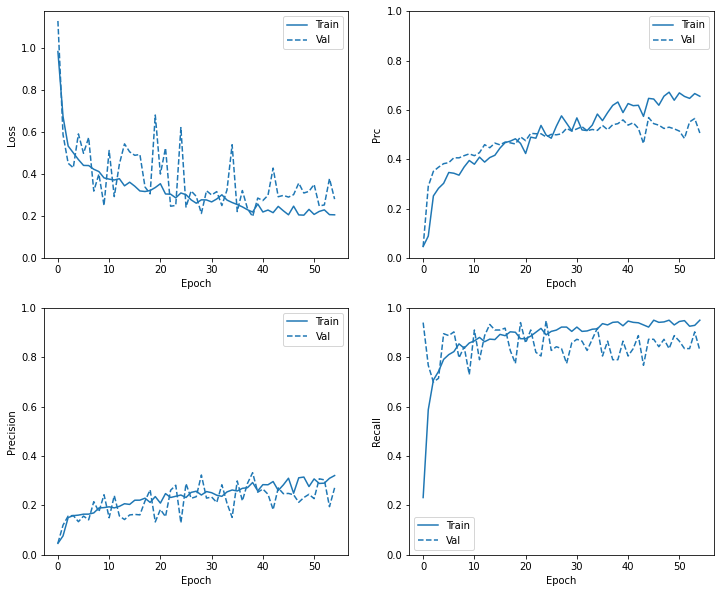

In [ ]:
plot_metrics(weighted_history, colors)

In [ ]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.3233443796634674
tp :  122.0
fp :  393.0
tn :  3024.0
fn :  37.0
accuracy :  0.8797538876533508
precision :  0.2368932068347931
recall :  0.7672955989837646
auc :  0.8787426352500916
prc :  0.4042332172393799

True Job Postings Detected (True Negatives):  3024
True Job Postings Incorrectly Detected (False Positives):  393
False Job Postings Missed (False Negatives):  37
False Job Postings Detected (True Positives):  122
Total False Job Postings:  159


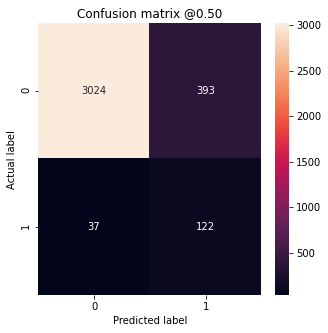

In [ ]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

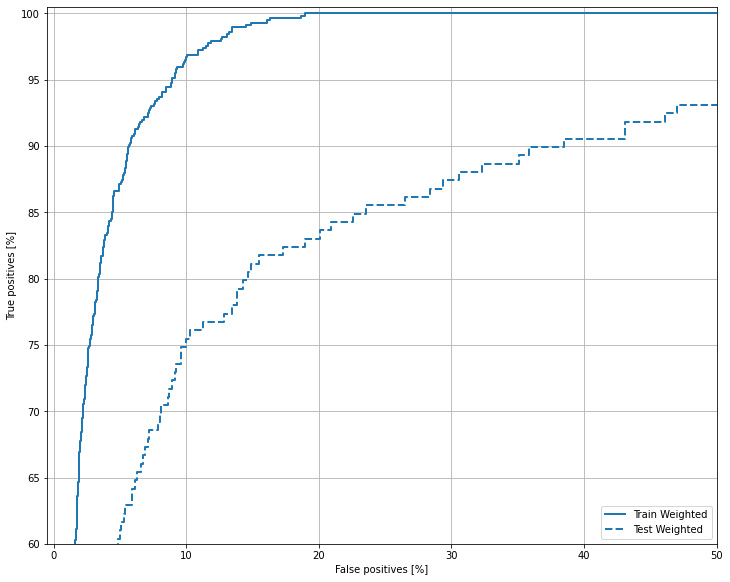

In [ ]:
plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[0])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

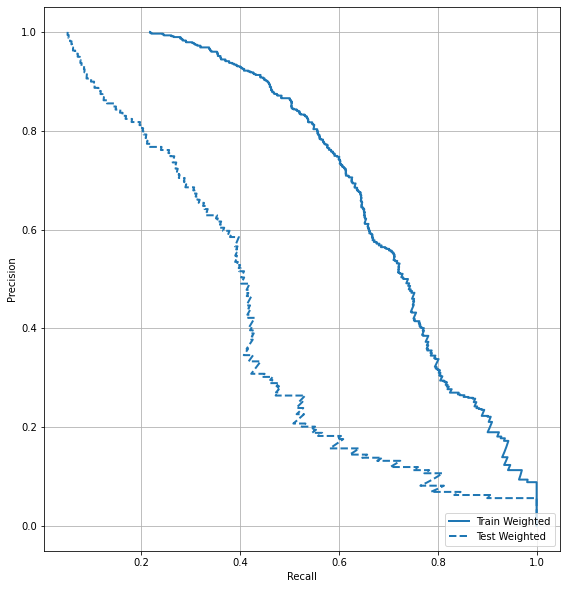

In [ ]:
plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[0])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
if MODEL in ['LSTM', 'BiLSTM']:
    keras.models.save_model(weighted_model, f'Model/LSTM/Classification/NN_{MODEL}')
else:
    keras.models.save_model(weighted_model, f'Model/Doc2Vec/Classification/NN_{MODEL}')

INFO:tensorflow:Assets written to: Model/LSTM/Classification/NN_DBOW/assets
